<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/developtemp/(0.8679)_Bidirectional_LSTM_12K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/ML/TP/12K IMDB Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <데이터셋 확인>

In [ ]:
import pandas as pd #dataframe 관한 함수 사용

df = pd.read_csv(path)
df #dataframe 미리보기

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive
...,...,...
11995,If there's one thing you can count on Disney t...,negative
11996,I wouldn't rent this one even on dollar rental...,negative
11997,Is there anything else on earth to be more ent...,negative
11998,There was a time when Joel Schumacher was rank...,negative


## <데이터 전처리>

sentiment(레이블) 전처리

In [ ]:
#정확도 비교를 쉽게 하기 위해 positive를 1, negative를 0으로 매핑
sentiment_mapping = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].replace(sentiment_mapping)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,"Petter Mattei's ""Love in the Time of Money"" is...",1
4,"Probably my all-time favorite movie, a story o...",1
...,...,...
11995,If there's one thing you can count on Disney t...,0
11996,I wouldn't rent this one even on dollar rental...,0
11997,Is there anything else on earth to be more ent...,0
11998,There was a time when Joel Schumacher was rank...,0


In [ ]:
labels=df['sentiment'].values #df의 sentiment 열을 np.array로 만듦

review 전처리

In [ ]:
!pip install html5lib

In [ ]:
!pip install BeautifulSoup4

In [ ]:
from bs4 import BeautifulSoup
import re #정규표현식
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')

#축약단어 푸는 함수
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#어근 추출하는 함수(스테머LancasterStemmer/PorterStemmer)
#stemmer=nltk.stem.LancasterStemmer()
#표제어 추출하는 함수(레머타이저)
#lemmatizer = WordNetLemmatizer()

def clean(review):
  review_text=BeautifulSoup(review, 'html5lib').get_text() # HTML 태그 제거
  review_text=re.sub('[^a-zA-Z]', ' ', review_text) # 영어 문자 제외 나머지 기호(쉼표, 느낌표, 숫자 등) 제거하고 공백으로 대체
  review_text=decontraction(review_text) # 축약단어 풀기
  review_text=review_text.lower() # 소문자 변환

  review_words=review_text.split() # 단어로 분해 시킨 뒤에
  #review_words=[stemmer.stem(word) for word in review_words] # 어근 추출
  #review_words=[lemmatizer.lemmatize(word) for word in review_words] # 표제어 추출

  stop_words = set(stopwords.words('english'))
  review_words=[w for w in review_words if w not in stop_words] # 불용어 제거

  review_text=' '.join(review_words)
  clean_review=review_text
  return clean_review

df['review']=df['review'].apply(clean)
df['review']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-29-86e9e9c4f6b6>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text=BeautifulSoup(review, 'html5lib').get_text() # HTML 태그 제거


0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        petter mattei love time money visually stunnin...
4        probably time favorite movie story selflessnes...
                               ...                        
11995    one thing count disney uncanny ability take st...
11996                    rent one even dollar rental night
11997    anything else earth enticing learn expects fra...
11998    time joel schumacher ranked quite high list fa...
11999    oh man hated movie granted site locations grea...
Name: review, Length: 12000, dtype: object

review 단어 수 세기>>한 문장당 최대 단어 개수는 600으로 여유롭게 정함.

In [ ]:
# 단어로 분리시키기, 배열로 생성됨
review_words = [sentence.split(' ') for sentence in df['review']]

# 분리 샘플 5개 보기
for i in range(5):
    print(review_words[i])

['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget', 'charm', 'for

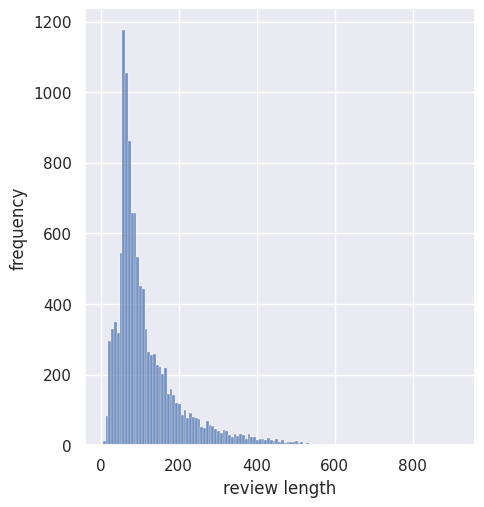

In [ ]:
# review 문장 길이(문장 별 단어 수) 통계
import seaborn as sns
import matplotlib.pyplot as plt

review_len = [len(sentence) for sentence in review_words]
review_len.sort()
sns.displot(review_len)
plt.xlabel('review length')
plt.ylabel('frequency')
plt.show()

In [ ]:
#타입 확인
print(type(df['review'])) #pandas series
print(type(review_words)) #list

<class 'pandas.core.series.Series'>
<class 'list'>


토큰화

In [ ]:
###### Hyperparameters ######
my_num_words = 60000 #embedding할 단어 개수
max_length = 600 #한 문장당 몇 개의 단어 개수를 제한으로 둘 지. 짧으면 패딩 추가, 길면 잘라냄
embedding_dim = 100 #30000개의 단어를 몇 차원의 벡터로 변환할 지 결정
padding_type='post'#패딩과 잘라내기를 뒤쪽에 적용
trunc_type='post'

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# num_words에 지정된 만큼만 숫자로 반환
tokenizer = Tokenizer(num_words=my_num_words)
tokenizer.fit_on_texts(review_words) #review_words를 tokenizer에 대입
review_tokens = tokenizer.texts_to_sequences(review_words) # tokenizer에 의해 구해진 단어의 index로 review_tokens 생성
review_tokens = pad_sequences(review_tokens,
                              padding=padding_type, truncating=trunc_type,
                              maxlen=max_length)
print(review_tokens[:5])

[[    3  1911   848 ...     0     0     0]
 [  254    34   233 ...     0     0     0]
 [   94   254    22 ...     0     0     0]
 [34664  6534    36 ...     0     0     0]
 [  125     7   371 ...     0     0     0]]


In [ ]:
#타입 확인
print(type(review_tokens)) #array

<class 'numpy.ndarray'>


In [ ]:
# tokenizer 확인
print(tokenizer.index_word[1])
print(tokenizer.index_word[29999])

movie
contemplations


## <모델 훈련>

In [ ]:
from sklearn.model_selection import train_test_split
#train_test_split 함수 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)[source]

train_texts, test_texts, train_labels, test_labels = train_test_split(review_tokens, labels, test_size=0.2, random_state=42)

In [ ]:
#타입 확인
print(type(train_texts))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
#참고 용어 설명
#에폭(epoch): 하나의 단위. 1에폭은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당함.
#미니 배치(mini batch): 전체 데이터 셋을 몇 개의 데이터 셋으로 나누었을 때, 그 작은 데이터 셋 뭉치
#배치사이즈(batch size): 하나의 미니 배치에 넘겨주는 데이터 갯수, 즉 한번의 배치마다 주는 샘플의 size
#이터레이션(iteration): 하나의 미니 배치를 학습할 때 1iteration이라고 한다. 즉, 미니 배치 갯수 = 이터레이션 수

######hyperparameters######
num_epochs = 4
batch_sz = 128
lr = 0.001 #learning rate
dr = 0.2 #dropout rate

## **양방향 LSTM**

In [ ]:
#양방향 LSTM
optim = keras.optimizers.Adam(learning_rate=lr)

model_LSTM2 = keras.Sequential(name="model_LSTM2", layers=[
    keras.layers.Embedding(my_num_words, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=dr)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_LSTM2.compile(loss='binary_crossentropy',
                    optimizer=optim,
                    metrics=['accuracy'])

model_LSTM2.summary()

Model: "model_LSTM2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 100)          6000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 6087601 (23.22 MB)
Trainable params: 6087601 (23.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
result_LSTM2 = model_LSTM2.fit(train_texts, train_labels, epochs=num_epochs, batch_size=batch_sz, verbose=1, validation_split=0.1)

Epoch 1/4
68/68 [==============================] - 29s 381ms/step - loss: 0.6023 - accuracy: 0.6652 - val_loss: 1.0781 - val_accuracy: 0.4938
Epoch 2/4
68/68 [==============================] - 14s 205ms/step - loss: 0.6618 - accuracy: 0.7035 - val_loss: 0.4430 - val_accuracy: 0.8271
Epoch 3/4
68/68 [==============================] - 12s 173ms/step - loss: 0.2493 - accuracy: 0.9116 - val_loss: 0.3554 - val_accuracy: 0.8667
Epoch 4/4
68/68 [==============================] - 12s 168ms/step - loss: 0.0817 - accuracy: 0.9742 - val_loss: 0.3962 - val_accuracy: 0.8604


<function matplotlib.pyplot.show(close=None, block=None)>

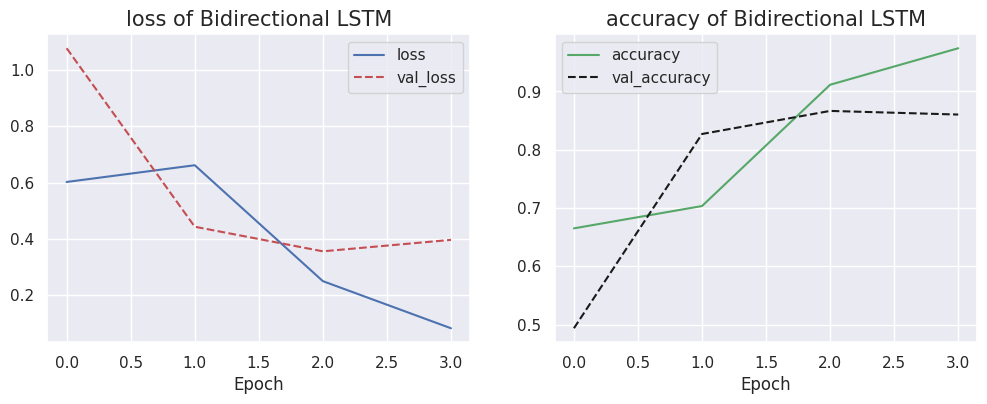

In [ ]:
#train, validation data에 대한 loss, accuracy 계산
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM', fontsize= 15)
plt.plot(result_LSTM2.history['loss'], 'b-', label='loss')
plt.plot(result_LSTM2.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM', fontsize= 15)
plt.plot(result_LSTM2.history['accuracy'], 'g-', label='accuracy')
plt.plot(result_LSTM2.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

75/75 [==============================] - 4s 36ms/step
Test Accuracy: 0.8679


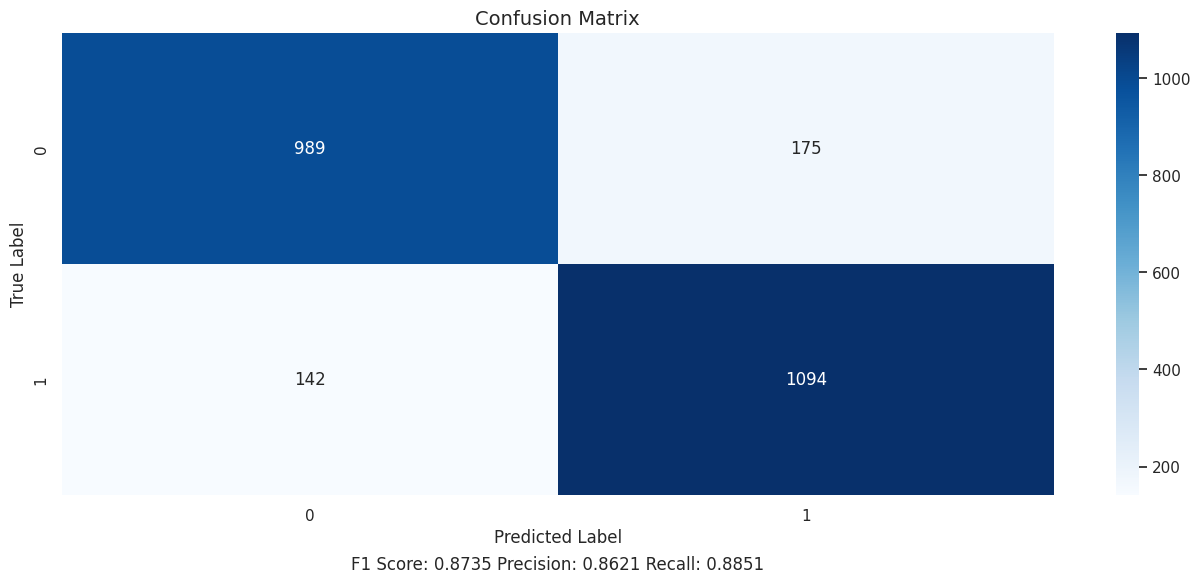

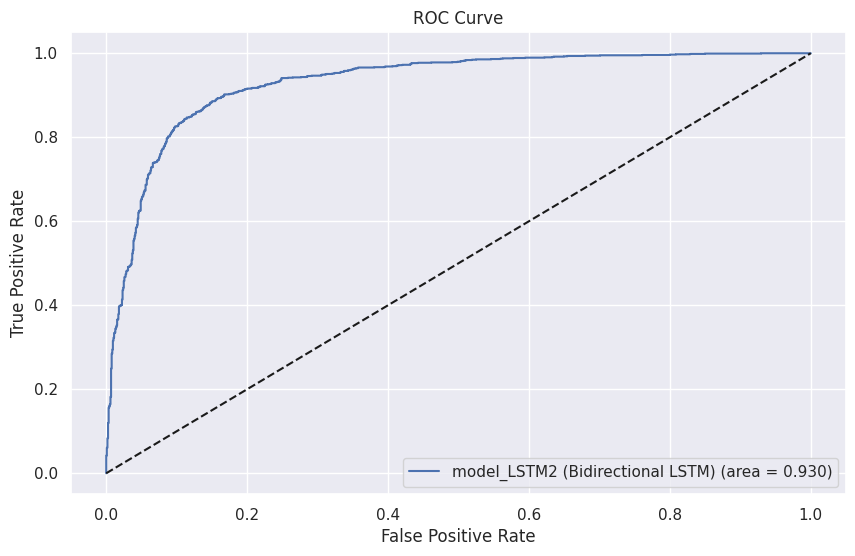

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 예측값 얻기
predictions = model_LSTM2.predict(test_texts)
predictions_binary = (predictions > 0.5).astype(int) #이진 분류.

# 평가 척도 계산
cm=confusion_matrix(test_labels, predictions_binary)#confusion matrix
f1=f1_score(test_labels, predictions_binary) #f1score
precision=precision_score(test_labels, predictions_binary)#precision
recall=recall_score(test_labels, predictions_binary)#recall
accuracy = accuracy_score(test_labels, predictions_binary) # accuracy

# 정확도 출력
print(f'Test Accuracy: {accuracy:.4f}')

#시각화
fig, axes = plt.subplots(figsize=(16, 6))

#시각화1-confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axes)
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1:.4f} Precision: {precision:.4f} Recall: {recall:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,fontsize=12)
plt.show()

#시각화2-ROC curve
fp, tp, _ = roc_curve(test_labels, predictions) #처음 두 값(fp 및 tp)만 압축을 풀고 나머지는 무시하도록 지시
auroc_baseline = roc_auc_score(test_labels, predictions)

plt.figure(figsize=(10, 6))
plt.plot(fp, tp, label=f'model_LSTM2 (Bidirectional LSTM) (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()